In [1]:
import pandas as pd
import numpy as np
import random
import warnings
# 忽略警告
warnings.filterwarnings("ignore")

import torch 
from torch.utils.data import random_split
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

from transformers import AutoTokenizer

from utils.dataset import *
from utils.train import *
from utils.model import *

# 固定随机种子
seed = 42
torch.manual_seed(seed)  # 设置PyTorch的随机种子
torch.cuda.manual_seed(seed)  # 设置GPU上的随机种子（如果使用GPU）
torch.cuda.manual_seed_all(seed)  # 设置所有GPU上的随机种子（如果使用多GPU）
np.random.seed(seed)  # 设置NumPy的随机种子
random.seed(seed)  # 设置Python标准库的随机种子

# 设置 cudnn 的确定性算法，避免不确定性操作
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# OCR特征提取部分
from paddleocr import PaddleOCR,draw_ocr
from PIL import Image
from tqdm import tqdm
import pandas as pd
import os
import logging

# 设置 PaddleOCR 的日志级别为 WARNING
logging.getLogger('ppocr').setLevel(logging.WARNING)

In [ ]:
# 训练数据
csv_path = '../../data/train.xlsx'
img_path = '../../data/images/'

# 测试数据
# csv_path = '../../data/test_ocr.xlsx'
# img_path = '../../data/images/'

data = pd.read_excel(csv_path)
ocr = PaddleOCR(lang='ch')

In [ ]:
# 使用tqdm包裹外部的循环
for index in tqdm(range(len(data)), total=len(data)):
    row = data.iloc[index]  # 使用 .iloc 明确获取每一行的数据
    images_list = row['images_list'].split('\t') if pd.notna(row['images_list']) else []
    if images_list:
        lst = []
        for end_path in images_list:
            # 此处的img_path是已经设定好了的image的存放位置
            path = os.path.join(img_path, end_path)
            if os.path.exists(path):  # 检查文件是否存在
                try:
                    ocr_model = ocr.ocr(path, cls=False)
                    for idx in range(len(ocr_model)):  # 注意这里应该是ocr_model而不是result
                        res = ocr_model[idx]
                        if res is not None:  # 检查 res 是否为 None
                            for line in res:
                                lst.append(line[-1][0])
                except Exception as e:
                    # 如果出现任何错误，打印错误信息并继续处理下一个文件
                    # print(f"Error processing file {path}: {e}")
                    continue
            else:
                # print(f"File not found: {path}")
                continue
        result = " ".join(lst)
        data.at[index, 'image_text'] = result  # 直接修改DataFrame中的值
    else:
        data.at[index, 'image_text'] = ''  # 如果没有图片，则设置为空字符串

In [ ]:
data.to_excel("'../../data/train_ocr.xlsx'")
# data.to_excel("'../../data/test_ocr.xlsx'")

In [2]:
data_path = '../../data/train_ocr.xlsx'
model_path = '../../model/xlnet/'
image_path = '../../data/images/'
test_path = '../../data/test_ocr.xlsx'

tokenizer = AutoTokenizer.from_pretrained(model_path)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [3]:
dataset = MultiModalDataset(excel_file=data_path,tokenizer=tokenizer,img_dir=image_path,transform=transform)

# 定义训练集和评估集的长度（80% 训练，20% 评估）
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# 使用 random_split 进行划分
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=16)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=16)

In [4]:
# 定义模型
model = MultimodalClassifier(num_classes=2,text_model=model_path)
if torch.cuda.device_count() > 1:
    print(f"使用 {torch.cuda.device_count()} 个 GPU!")
    model = nn.DataParallel(model)  # 将模型放到多个GPU上

# 定义优化器
optimizer = optim.AdamW(model.parameters(), lr=2e-5) # Adam优化器（优化版）
scheduler = CosineAnnealingLR(optimizer, T_max=30,eta_min=1e-6) # 余弦退火

# 定义分类损失函数
criterion = nn.CrossEntropyLoss()

使用 3 个 GPU!


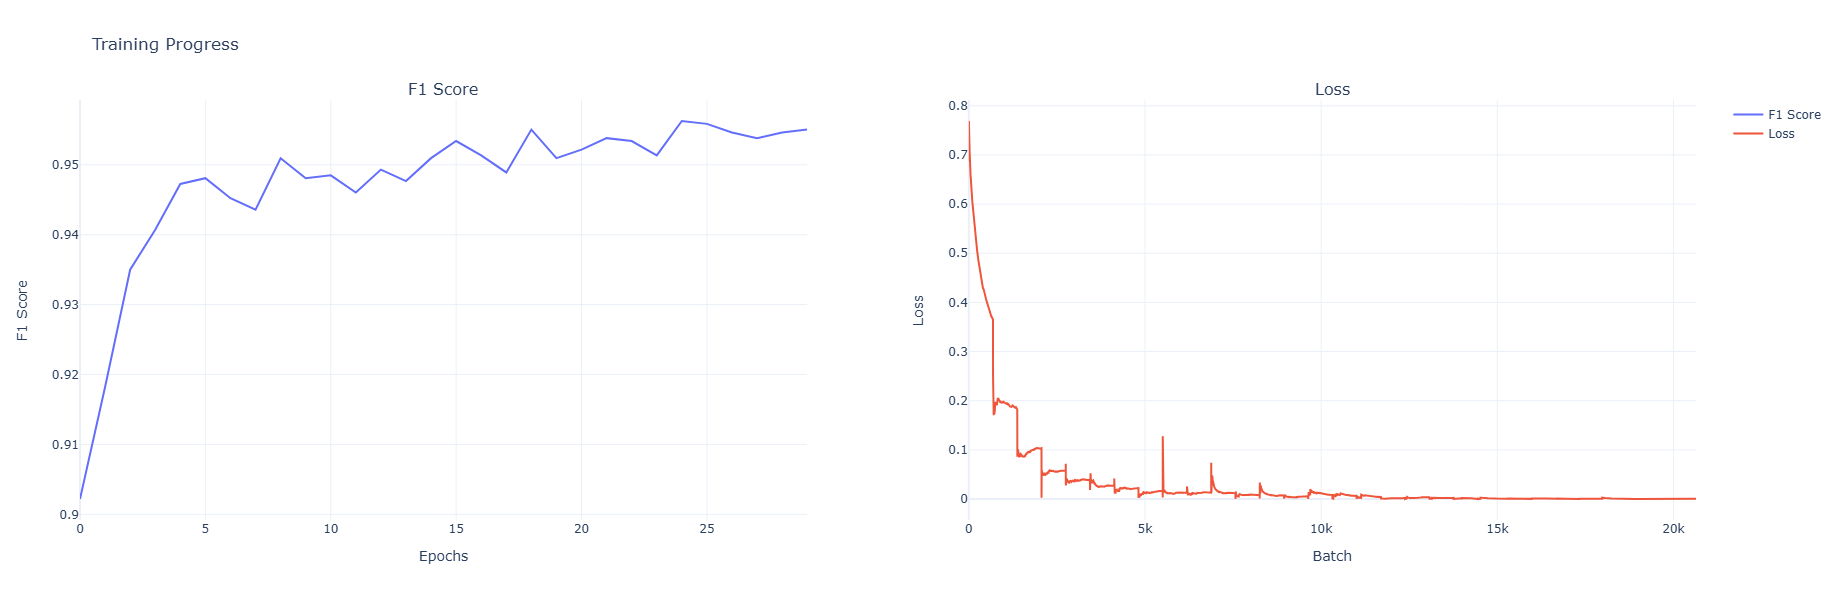

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20640/20640 [7:21:30<00:00,  1.28s/it, Loss=0.0003, F1=0.9546]


In [5]:
trainer = Trainer(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    num_epochs=30,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    enable_visualization=True,
    is_jupyter=True
)

trainer.train()

## 预测结果

In [6]:
test_dataset = MultiModalDataset(excel_file=test_path,img_dir=image_path,tokenizer=tokenizer,transform=transform)
test_loader = DataLoader(test_dataset, batch_size=24, shuffle=False, num_workers=16)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultimodalClassifier(num_classes=2,text_model=model_path).to(device)
model = nn.DataParallel(model)

model.load_state_dict(torch.load('./save/best_model.pth', weights_only=True))    

model.eval()
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        ocrinput_ids = batch['ocrinput_ids'].to(device)
        ocrattention_mask = batch['ocrattention_mask'].to(device)
        images = batch['images'].to(device)

        # 预测
        outputs = model(input_ids, attention_mask, ocrinput_ids, ocrattention_mask, images)
        _, preds = torch.max(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())

In [7]:
testDF = pd.read_excel(test_path)
testDF['target'] = all_preds
testDF[['id','target']].to_csv('pred.csv')